In [ ]:
#@title Installing Environments 
!pip install gymnasium
!pip install highway-env

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 13.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.8/103.8 kB 3.5 MB/s eta 0:00:00


In [ ]:
#@title Importing Libraries
import gymnasium as gym
import highway_env
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import operator

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#@title Replay Memory for DQN and DDQN
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
#@title Neural Net Class
class ANN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [ ]:
#@title Some Global Constants

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 400
TAU = 0.005
LR = 5e-4

In [ ]:
#@title Function that selects epsilon greedy action

def select_action(state):
    global eps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * eps_done / EPS_DECAY)
    # steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)



In [ ]:
#@title Optimization Function DQN
def optimize_model_dqn():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a)
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    return loss

In [ ]:
#@title Optimization Function DDQN
def optimize_model_ddqn():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) 
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        policy_best_actions = policy_net(non_final_next_states).argmax(dim = 1, keepdim = True)
        next_state_values[non_final_mask] = target_net(non_final_next_states).gather(1, policy_best_actions)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    return loss

In [ ]:
#@title Functions for PERDQN

# Replay Buffer
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, experiences_per_sampling,compute_weights):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            experiences_per_sampling (int): number of experiences to sample during a sampling iteration
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.experiences_per_sampling = experiences_per_sampling
        
        self.alpha = 0.5
        self.alpha_decay_rate = 0.99
        self.beta = 0.5
        self.beta_growth_rate = 1.001
        # self.seed = random.seed(seed)
        self.compute_weights = compute_weights
        self.experience_count = 0
        
        self.experience = namedtuple("Experience", 
            field_names=["state", "action", "reward", "next_state", "done"])
        self.data = namedtuple("Data", 
            field_names=["priority", "probability", "weight","index"])

        indexes = []
        datas = []
        for i in range(buffer_size):
            indexes.append(i)
            d = self.data(0,0,0,i)
            datas.append(d)
        
        self.memory = {key: self.experience for key in indexes}
        self.memory_data = {key: data for key,data in zip(indexes, datas)}
        self.sampled_batches = []
        self.current_batch = 0
        self.priorities_sum_alpha = 0
        self.priorities_max = 1
        self.weights_max = 1
    
    def update_priorities(self, tds, indices):
        for td, index in zip(tds, indices):
            N = min(self.experience_count, self.buffer_size)

            updated_priority = td[0]
            if updated_priority > self.priorities_max:
                self.priorities_max = updated_priority
            
            if self.compute_weights:
                updated_weight = ((N * updated_priority)**(-self.beta))/self.weights_max
                if updated_weight > self.weights_max:
                    self.weights_max = updated_weight
            else:
                updated_weight = 1

            old_priority = self.memory_data[index].priority
            self.priorities_sum_alpha += updated_priority**self.alpha - old_priority**self.alpha
            updated_probability = td[0]**self.alpha / self.priorities_sum_alpha
            data = self.data(updated_priority, updated_probability, updated_weight, index) 
            self.memory_data[index] = data

    def update_memory_sampling(self):
        """Randomly sample X batches of experiences from memory."""
        # X is the number of steps before updating memory
        self.current_batch = 0
        values = list(self.memory_data.values())
        random_values = random.choices(self.memory_data, 
                                       [data.probability for data in values], 
                                       k=self.experiences_per_sampling)
        self.sampled_batches = [random_values[i:i + self.batch_size] 
                                    for i in range(0, len(random_values), self.batch_size)]

    def update_parameters(self):
        self.alpha *= self.alpha_decay_rate
        self.beta *= self.beta_growth_rate
        if self.beta > 1:
            self.beta = 1
        N = min(self.experience_count, self.buffer_size)
        self.priorities_sum_alpha = 0
        sum_prob_before = 0
        for element in self.memory_data.values():
            sum_prob_before += element.probability
            self.priorities_sum_alpha += element.priority**self.alpha
        sum_prob_after = 0
        for element in self.memory_data.values():
            probability = element.priority**self.alpha / self.priorities_sum_alpha
            sum_prob_after += probability
            weight = 1
            if self.compute_weights:
                weight = ((N *  element.probability)**(-self.beta))/self.weights_max
            d = self.data(element.priority, probability, weight, element.index)
            self.memory_data[element.index] = d
        print("sum_prob before", sum_prob_before)
        print("sum_prob after : ", sum_prob_after)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        self.experience_count += 1
        index = self.experience_count % self.buffer_size

        if self.experience_count > self.buffer_size:
            temp = self.memory_data[index]
            self.priorities_sum_alpha -= temp.priority**self.alpha
            if temp.priority == self.priorities_max:
                self.memory_data[index].priority = 0
                self.priorities_max = max(self.memory_data.items(), key=operator.itemgetter(1)).priority
            if self.compute_weights:
                if temp.weight == self.weights_max:
                    self.memory_data[index].weight = 0
                    self.weights_max = max(self.memory_data.items(), key=operator.itemgetter(2)).weight

        priority = self.priorities_max
        weight = self.weights_max
        self.priorities_sum_alpha += priority ** self.alpha
        probability = priority ** self.alpha / self.priorities_sum_alpha
        e = self.experience(state, action, reward, next_state, done)
        self.memory[index] = e
        d = self.data(priority, probability, weight, index)
        self.memory_data[index] = d
            
    def sample(self):
        sampled_batch = self.sampled_batches[self.current_batch]
        self.current_batch += 1
        experiences = []
        weights = []
        indices = []
        
        for data in sampled_batch:
            experiences.append(self.memory.get(data.index))
            weights.append(data.weight)
            indices.append(data.index)

        states = torch.from_numpy(
            np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(
            np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(
            np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(
            np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(
            np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones, weights, indices)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

# The ANN networks 
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_size)

        

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Agent Class 
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size,compute_weights = False):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        # self.seed = random.seed(seed)
        self.compute_weights = compute_weights

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        self.criterion = nn.MSELoss()

        # Replay memory
        self.memory = ReplayBuffer(
            action_size, BUFFER_SIZE, BATCH_SIZE, EXPERIENCES_PER_SAMPLING,compute_weights)
        # Initialize time step (for updating every UPDATE_NN_EVERY steps)
        self.t_step_nn = 0
        # Initialize time step (for updating every UPDATE_MEM_PAR_EVERY steps)
        self.t_step_mem_par = 0
        # Initialize time step (for updating every UPDATE_MEM_EVERY steps)
        self.t_step_mem = 0
    
    def step(self, state, action, reward, next_state, done):
        loss = None
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_NN_EVERY time steps.
        self.t_step_nn = (self.t_step_nn + 1) % UPDATE_NN_EVERY
        self.t_step_mem = (self.t_step_mem + 1) % UPDATE_MEM_EVERY
        self.t_step_mem_par = (self.t_step_mem_par + 1) % UPDATE_MEM_PAR_EVERY
        if self.t_step_mem_par == 0:
            self.memory.update_parameters()
        if self.t_step_nn == 0:
            # If enough samples are available in memory, get random subset and learn
            if self.memory.experience_count > EXPERIENCES_PER_SAMPLING:
                sampling = self.memory.sample()
                loss = self.learn(sampling, GAMMA)
        if self.t_step_mem == 0:
            self.memory.update_memory_sampling()
        return loss

    def act(self, state, eps):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def avg_qval(self,state):
      state = torch.from_numpy(state).float().unsqueeze(0).to(device)
      action_values = self.qnetwork_local(state)
      return np.mean(action_values.cpu().data.numpy())


    def learn(self, sampling, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            sampling (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones, weights, indices  = sampling

        ## TODO: compute and minimize the loss        
        q_target = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        expected_values = rewards + gamma*q_target*(1-dones)
        output = self.qnetwork_local(states).gather(1, actions)
        loss = F.mse_loss(output, expected_values)
        if self.compute_weights:
            with torch.no_grad():
                weight = sum(np.multiply(weights, loss.data.cpu().numpy()))
            loss *= weight
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

        # ------------------- update priorities ------------------- #
        delta = abs(expected_values - output.detach()).numpy()
        self.memory.update_priorities(delta, indices)  
        return loss

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

            

In [ ]:
#@title Function to evaluate the policies by running for 150 episodes 

def evaluate(env,policy_net):
  state, info = env.reset()
  state = state.flatten()

  episode_rewards = np.array([])
  avg_qval = []

  for n_episode in range(150):
    state, info = env.reset()
    state = state.flatten()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    avg_qval.append(torch.mean(policy_net(state)).item())

    ep_reward = 0
    for steps in range(1000):
      action = policy_net(state).max(1)[1].view(1, 1)
      observation, reward, terminated, truncated, _ = env.step(action.item())
      observation = observation.flatten()
      ep_reward += reward
      reward = torch.tensor([reward], device=device)
      done = terminated or truncated

      if terminated:
        next_state = None
      else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

      state = next_state

      if done:
        episode_rewards = np.append(episode_rewards,ep_reward)
        if n_episode%10 == 0:
          print('Episodes', n_episode)
          print('Avg Reward', np.mean(episode_rewards))
        break

  # Plot of Returns
  plt.plot([sum(episode_rewards[:i + 1])/(i + 1) for i in range(len(episode_rewards))])
  plt.title('Avg Rewards vs Episode')
  plt.show()

  plt.plot(avg_qval)
  plt.title('Avg Q Value of Start State vs Epsiodes')



In [ ]:
#@title DQN for Intersection 
env = gym.make("intersection-v0")
eps_done = 0

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
state = state.flatten()
n_observations = len(state)

policy_net = ANN(n_observations, n_actions).to(device)
target_net = ANN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(100000)

if torch.cuda.is_available():
    num_episodes = 500
else:
    num_episodes = 500

eps_done = 0
episode_rewards_dqn = np.array([])
avg_qval_dqn = []
losses_dqn = []
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = state.flatten()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    avg_qval_dqn.append(torch.mean(policy_net(state)).item())
    ep_reward = 0
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        observation = observation.flatten()
        ep_reward += reward
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        loss = optimize_model_dqn()
        if loss:
          losses_dqn.append(loss.item())

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_rewards_dqn = np.append(episode_rewards_dqn,ep_reward)
            eps_done += 1
            if eps_done%10 == 0:
              print('Episodes', eps_done)
              print('Avg Reward', np.mean(episode_rewards_dqn))
            break
        

print('Complete')

/usr/local/lib/python3.9/dist-packages/gymnasium/envs/registration.py:523: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
/usr/local/lib/python3.9/dist-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (15, 7)
  logger.warn(


Episodes 10
Avg Reward 0.6020894392866918
Episodes 20
Avg Reward 1.0898975909278144
Episodes 30
Avg Reward 1.413248856256981
Episodes 40
Avg Reward 1.3104106828389397
Episodes 50
Avg Reward 1.247338825957075
Episodes 60
Avg Reward 1.6078155622821022
Episodes 70
Avg Reward 2.1244738827091547
Episodes 80
Avg Reward 2.164849288168493
Episodes 90
Avg Reward 2.014517283443271
Episodes 100
Avg Reward 2.403548235893284
Episodes 110
Avg Reward 2.581053171950478
Episodes 120
Avg Reward 2.798717831130237
Episodes 130
Avg Reward 2.839205299071242
Episodes 140
Avg Reward 2.994830016425301
Episodes 150
Avg Reward 2.956983438942081
Episodes 160
Avg Reward 2.8471719740082015
Episodes 170
Avg Reward 2.8855736225959543
Episodes 180
Avg Reward 2.9087954163841756
Episodes 190
Avg Reward 3.015025585118379
Episodes 200
Avg Reward 3.1458614853972686
Episodes 210
Avg Reward 3.1342114138454886
Episodes 220
Avg Reward 3.167280998817262
Episodes 230
Avg Reward 3.1887793694000552
Episodes 240
Avg Reward 3.307300

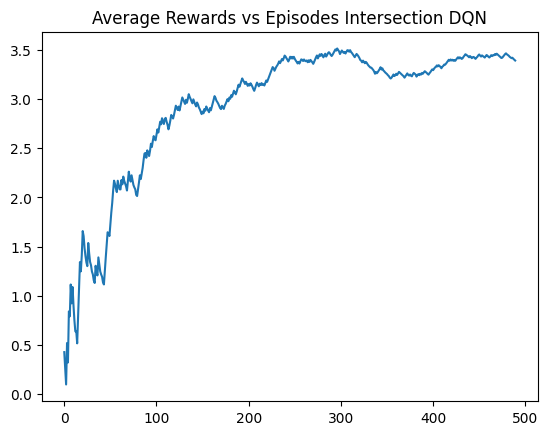

In [ ]:
#@title Intersection DQN Average Rewards vs Episodes Plot 
plot_dqn = []
for i in range(10,len(episode_rewards_dqn)):
  plot_dqn.append(sum(episode_rewards_dqn[:i + 1])/(i + 1))
plt.title('Average Rewards vs Episodes Intersection DQN')
plt.plot(plot_dqn)
plt.show()



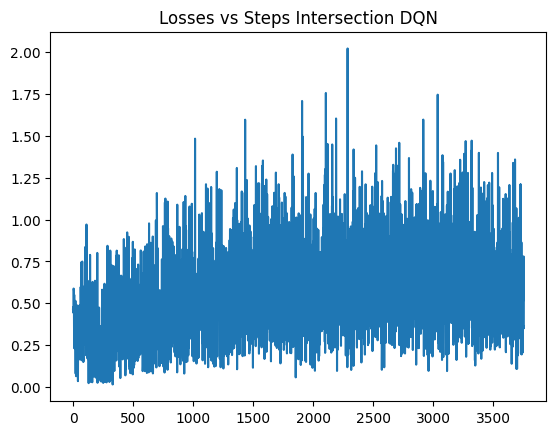

In [ ]:
#@title Intersection DQN Loss vs Steps Plot  

plt.plot(losses_dqn)
plt.title('Losses vs Steps Intersection DQN')
plt.show()

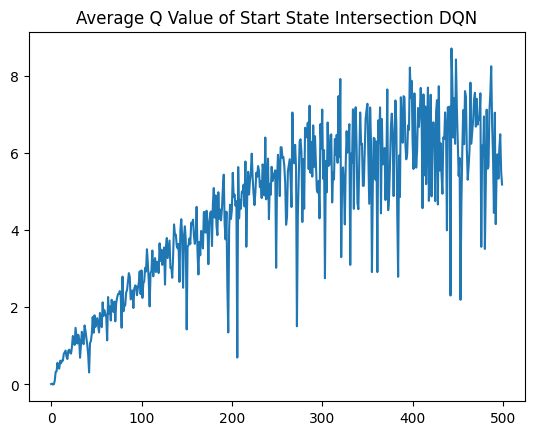

In [ ]:
#@title Intersection DQN Average Q Value of Start State vs Episodes Plot 

plt.plot(avg_qval_dqn)
plt.title('Average Q Value of Start State Intersection DQN')
plt.show()

Episodes 0
Avg Reward 9.617420714945025
Episodes 10
Avg Reward 5.70874504652312
Episodes 20
Avg Reward 4.5341083736956715
Episodes 30
Avg Reward 3.7020589219654254
Episodes 40
Avg Reward 4.269324771388073
Episodes 50
Avg Reward 4.20671060335921
Episodes 60
Avg Reward 4.096649151175445
Episodes 70
Avg Reward 4.227294199039969
Episodes 80
Avg Reward 4.118443202226412
Episodes 90
Avg Reward 4.32083071503267
Episodes 100
Avg Reward 4.128696974645196
Episodes 110
Avg Reward 4.194722872238845
Episodes 120
Avg Reward 4.013568486607132
Episodes 130
Avg Reward 3.8508972049921346
Episodes 140
Avg Reward 3.9643302205582356


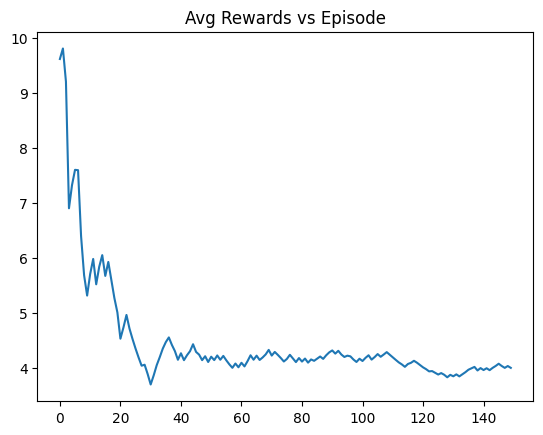

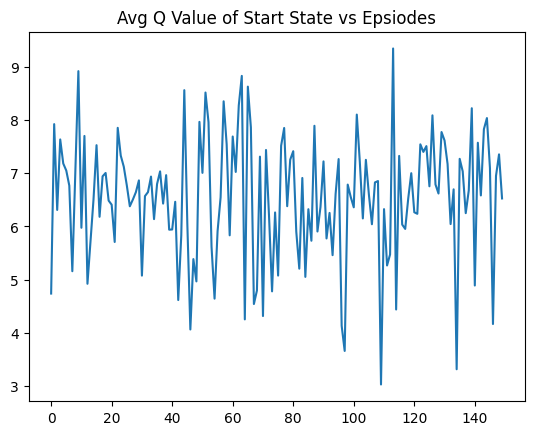

In [ ]:
#@title Evaluating Intersection DQN for 150 episodes

evaluate(env,policy_net)

In [ ]:
#@title DDQN for intersection 
EPS_DECAY = 40
env = gym.make("intersection-v0")
eps_done = 0

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
state = state.flatten()
n_observations = len(state)

policy_net = ANN(n_observations, n_actions).to(device)
target_net = ANN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

if torch.cuda.is_available():
    num_episodes = 500
else:
    num_episodes = 500

eps_done = 0
episode_rewards_ddqn = np.array([])
avg_qval_ddqn = []
losses_ddqn = []
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = state.flatten()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    avg_qval_ddqn.append(torch.mean(policy_net(state)).item())


    

    ep_reward = 0
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        observation = observation.flatten()
        ep_reward += reward
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        loss = optimize_model_ddqn()
        if loss:
          losses_ddqn.append(loss.item())

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_rewards_ddqn = np.append(episode_rewards_ddqn,ep_reward)
            eps_done += 1
            if eps_done%10 == 0:
              print('Episodes', eps_done)
              print('Avg Reward', np.mean(episode_rewards_ddqn))
            break
        

print('Complete')

/usr/local/lib/python3.9/dist-packages/gymnasium/envs/registration.py:523: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
/usr/local/lib/python3.9/dist-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (15, 7)
  logger.warn(


Episodes 10
Avg Reward 2.053581777933654
Episodes 20
Avg Reward 1.072034394365105
Episodes 30
Avg Reward 2.3991370388434694
Episodes 40
Avg Reward 2.455591084650694
Episodes 50
Avg Reward 2.0331042263396135
Episodes 60
Avg Reward 2.1867565087188194
Episodes 70
Avg Reward 1.9889107077653965
Episodes 80
Avg Reward 2.5767611596737297
Episodes 90
Avg Reward 2.63683027631037
Episodes 100
Avg Reward 2.5958157535360487
Episodes 110
Avg Reward 2.720467942946808
Episodes 120
Avg Reward 2.835112350655223
Episodes 130
Avg Reward 2.8157997378050856
Episodes 140
Avg Reward 2.7438926476004912
Episodes 150
Avg Reward 2.9426014286671847
Episodes 160
Avg Reward 3.0340216278995684
Episodes 170
Avg Reward 3.2139796748205973
Episodes 180
Avg Reward 3.2983750075523517
Episodes 190
Avg Reward 3.3547278834607237
Episodes 200
Avg Reward 3.348186952311367
Episodes 210
Avg Reward 3.2111588785527223
Episodes 220
Avg Reward 3.1761932350694715
Episodes 230
Avg Reward 3.2040783320163513
Episodes 240
Avg Reward 3.26

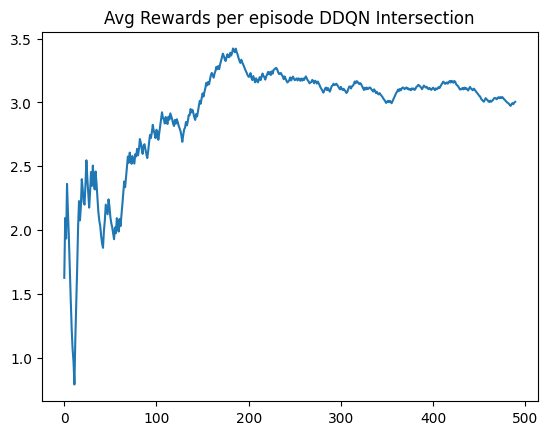

In [ ]:
#@title Intersection DDQN Average Rewards vs Episodes Plot 
plot_ddqn = []
for i in range(10,len(episode_rewards_ddqn)):
  plot_ddqn.append(sum(episode_rewards_ddqn[:i + 1])/(i + 1))

plt.title("Avg Rewards per episode DDQN Intersection")
plt.plot(plot_ddqn)
plt.show()

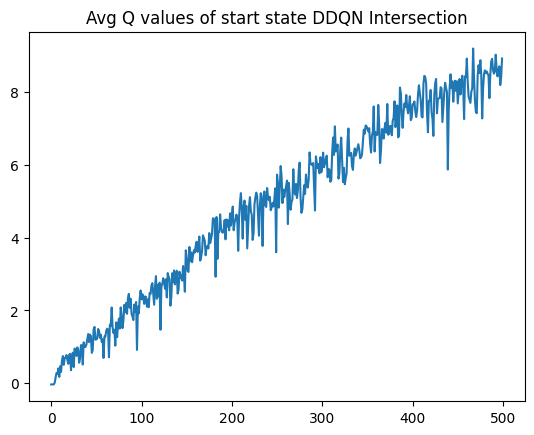

In [ ]:
#@title Intersection DDQN Average Q Value of Start State vs Episodes Plot 

plt.plot(avg_qval_ddqn)
plt.title('Avg Q values of start state DDQN Intersection')
plt.show()

Text(0.5, 1.0, 'Losses per step DDQN Intersection')

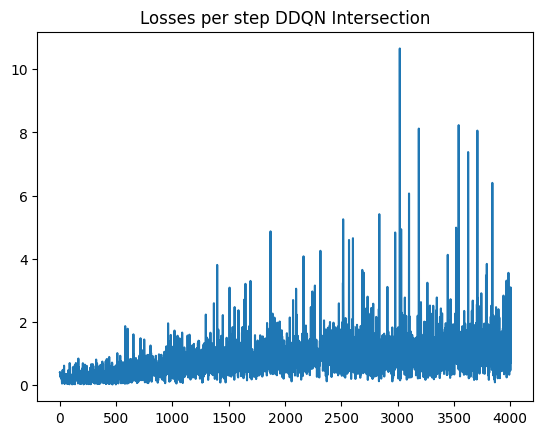

In [ ]:
#@title Intersection DDQN Loss vs Steps Plot  

plt.plot(losses_ddqn)
plt.title('Losses per step DDQN Intersection')

Episodes 0
Avg Reward 0.0
Episodes 10
Avg Reward 2.457678316299998
Episodes 20
Avg Reward 2.34025101351779
Episodes 30
Avg Reward 2.371480007442546
Episodes 40
Avg Reward 2.369105254949607
Episodes 50
Avg Reward 2.536995927985491
Episodes 60
Avg Reward 2.3851912256753165
Episodes 70
Avg Reward 2.0689588030009545
Episodes 80
Avg Reward 2.262778847243967
Episodes 90
Avg Reward 2.224520335545552
Episodes 100
Avg Reward 2.482404624014352
Episodes 110
Avg Reward 2.3928220527670576
Episodes 120
Avg Reward 2.3994228443862187
Episodes 130
Avg Reward 2.5830304502899817
Episodes 140
Avg Reward 2.5711754610446937


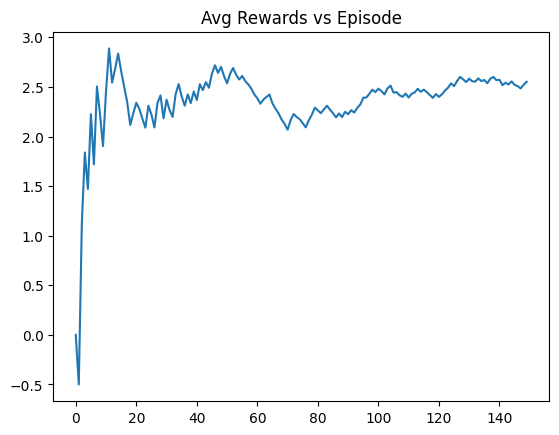

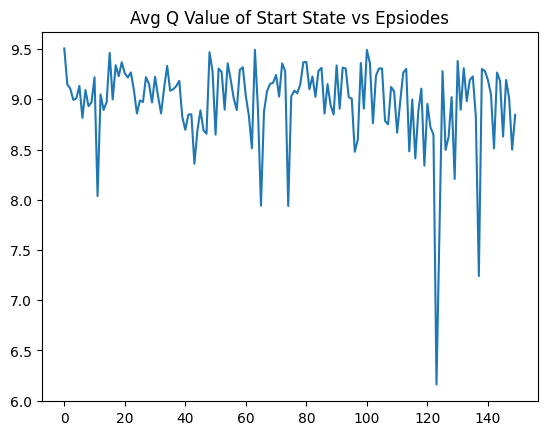

In [ ]:
#@title Evaluating Intersection DDQN 
evaluate(env,policy_net)

/usr/local/lib/python3.9/dist-packages/gymnasium/envs/registration.py:523: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
/usr/local/lib/python3.9/dist-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (15, 7)
  logger.warn(


Episode 10	Average Score: 0.38
Episode 20	Average Score: 1.28
Episode 30	Average Score: 0.67
Episode 40	Average Score: 0.73
Episode 50	Average Score: 0.84
Episode 60	Average Score: 1.05
Episode 70	Average Score: 1.33
Episode 80	Average Score: 1.33
Episode 90	Average Score: 1.41
Episode 100	Average Score: 1.44
Episode 110	Average Score: 1.75
Episode 120	Average Score: 1.72
Episode 130	Average Score: 1.88
Episode 140	Average Score: 1.88
Episode 150	Average Score: 1.91
Episode 160	Average Score: 2.00
Episode 170	Average Score: 2.08
Episode 180	Average Score: 2.14
Episode 190	Average Score: 2.15
Episode 200	Average Score: 2.24
Episode 210	Average Score: 2.38
Episode 220	Average Score: 2.31
Episode 230	Average Score: 2.49
Episode 240	Average Score: 2.47
Episode 250	Average Score: 2.50
sum_prob before 1.0254865499635208
sum_prob after :  0.9999999999999988
Episode 260	Average Score: 2.50
Episode 270	Average Score: 2.55
Episode 280	Average Score: 2.60
Episode 290	Average Score: 2.59
Episode 3

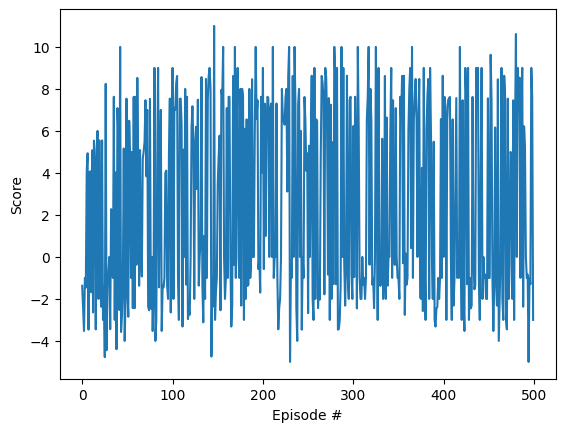

In [ ]:
#@title PERDQN for intersection 

UPDATE_NN_EVERY = 1        # how often to update the network
BUFFER_SIZE = int(1e5)      # replay buffer size

# prioritized experience replay
UPDATE_MEM_EVERY = 20          # how often to update the priorities
UPDATE_MEM_PAR_EVERY = 3000     # how often to update the hyperparameters
EXPERIENCES_PER_SAMPLING = math.ceil(BATCH_SIZE * UPDATE_MEM_EVERY / UPDATE_NN_EVERY)

env = gym.make('intersection-v0')
state,_ = env.reset()
state = state.flatten()
agent = Agent(state_size=len(state), action_size=env.action_space.n)

n_episodes=500; max_t=1000; eps_start=1.0; eps_end=0.01; eps_decay=0.995;
"""Deep Q-Learning.

Params
======
    n_episodes (int): maximum number of training episodes
    max_t (int): maximum number of timesteps per episode
    eps_start (float): starting value of epsilon, for epsilon-greedy action selection
    eps_end (float): minimum value of epsilon
    eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
"""
scores = []                        # list containing scores from each episode
eps = eps_start                    # initialize epsilon


episode_rewards_perdqn = np.array([])
losses_perdqn = []
avg_qval_perdqn = []
for i_episode in range(1, n_episodes+1):
  state,_ = env.reset()
  state = state.flatten()
  avg_qval_perdqn.append(agent.avg_qval(state))

  score = 0
  for t in range(max_t):
      action = agent.act(state, eps)
      next_state, reward, done,truncated, _ = env.step(action)
      next_state = next_state.flatten()
      loss = agent.step(state, action, reward, next_state, done)
      if loss:
        losses_perdqn.append(loss.item())
      state = next_state
      score += reward
      if done:
        break 
  episode_rewards_perdqn = np.append(episode_rewards_perdqn,score)

  eps = max(eps_end, eps_decay*eps) # decrease epsilon
  if i_episode % 10 == 0:
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(episode_rewards_perdqn)))




# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(episode_rewards_perdqn)), episode_rewards_perdqn)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

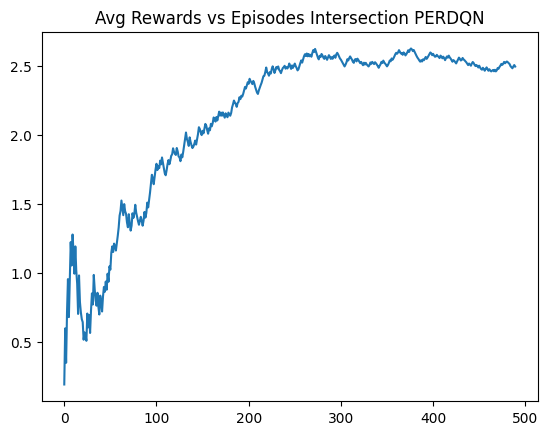

In [ ]:
#@title Intersection PERDQN Average Rewards vs Episodes Plot 

plot_perdqn = []
for i in range(10,len(episode_rewards_perdqn)):
  plot_perdqn.append(sum(episode_rewards_perdqn[:i + 1])/(i + 1))
plt.title('Avg Rewards vs Episodes Intersection PERDQN')
plt.plot(plot_perdqn)
plt.show()

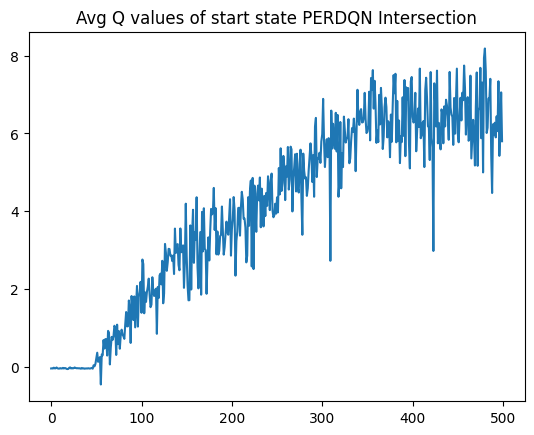

In [ ]:
#@title Intersection PERDQN Avg Q Value of Start State vs Episodes Plot  

plt.plot(avg_qval_perdqn)
plt.title('Avg Q values of start state PERDQN Intersection')
plt.show()

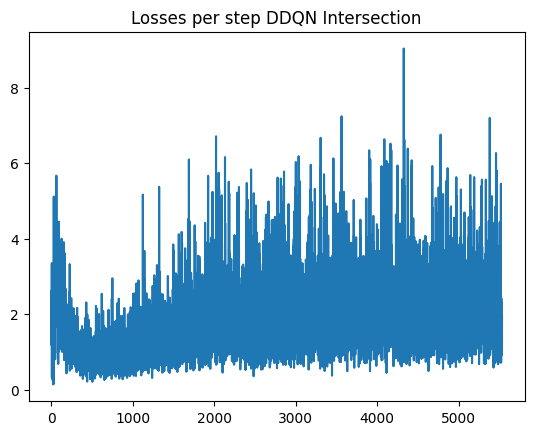

In [ ]:
#@title Intersection PERDQN Loss vs Steps Plot  

plt.plot(losses_perdqn)
plt.title('Losses per step DDQN Intersection')
plt.show()

Episodes 0
Avg Reward -1.0
Episodes 10
Avg Reward 2.736526510848445
Episodes 20
Avg Reward 2.6109503545953596
Episodes 30
Avg Reward 2.0964525600089385
Episodes 40
Avg Reward 2.074952408183008
Episodes 50
Avg Reward 2.1144107514447525
Episodes 60
Avg Reward 2.3493087806297375
Episodes 70
Avg Reward 2.3924014374894105
Episodes 80
Avg Reward 2.3491996541896807
Episodes 90
Avg Reward 2.6376673512460456
Episodes 100
Avg Reward 2.746379823886709
Episodes 110
Avg Reward 2.675185673805378
Episodes 120
Avg Reward 2.8330252779845355
Episodes 130
Avg Reward 2.911939834757325
Episodes 140
Avg Reward 2.9744898770616808


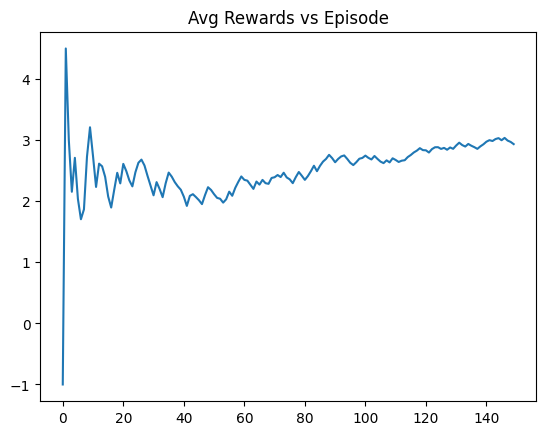

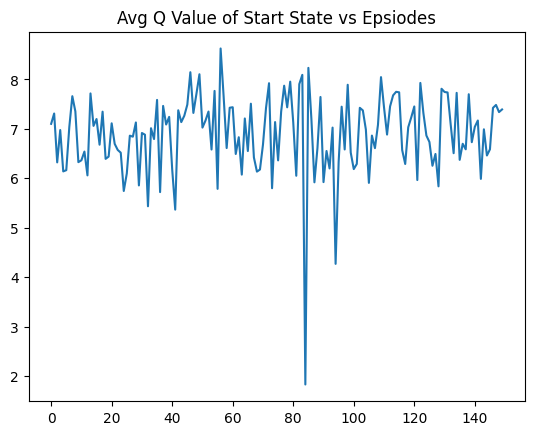

In [ ]:
#@title Evaluating PERDQN Intersection 
policy_net_perdqn = agent.qnetwork_local
evaluate(env,policy_net_perdqn)

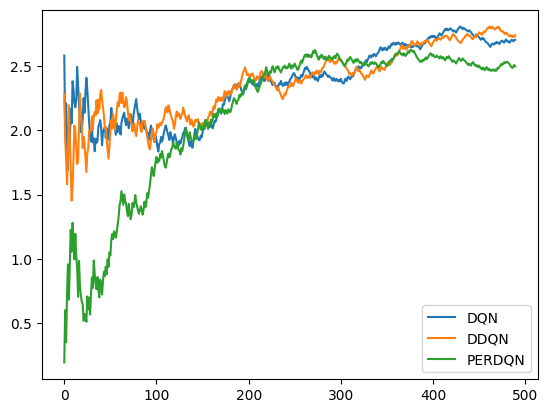

In [ ]:
#@title Plotting DQN and DDQN and PERDQN Rewards together 

plot_dqn = []
plot_ddqn = []
plot_perdqn = []
for i in range(10,len(episode_rewards_dqn)):
  plot_dqn.append(sum(episode_rewards_dqn[:i + 1])/(i + 1))
for i in range(10,len(episode_rewards_ddqn)):
  plot_ddqn.append(sum(episode_rewards_ddqn[:i + 1])/(i + 1))
for i in range(10,len(episode_rewards_perdqn)):
  plot_perdqn.append(sum(episode_rewards_perdqn[:i + 1])/(i + 1))


plt.plot(plot_dqn, label = 'DQN')
plt.plot(plot_ddqn, label = 'DDQN')
plt.plot(plot_perdqn, label = 'PERDQN')
plt.legend()
plt.show()


Q1.C 

Results: We obtain higher loss for PERDQN as compared to DQN and DDQN. This is because PERDQN is based on assigniing higher priority to more error. 
On multiple runs, it can be observed that generally PERDQN outperforms DQN and DDQN. Both DQN and DDQN perform similarly, with PERDQN only slightly better on average. 

Runtime: Due to hardware constraints the algorithm could only be run for 500 episodes. For 500 Episodes, DQN and DDQN both took 10 minutes, whereas PERDQN took a little bit more time, with 15 minutes. This is because PERDQN has a queue based on priority which increases runtime. 

In [ ]:
#@title DQN for Highway Greyscale 
EPS_DECAY = 25

if torch.cuda.is_available():
    num_episodes = 200
else:
    num_episodes = 200

env = gym.make("highway-fast-v0")
config = {
       "observation": {
           "type": "GrayscaleObservation",
           "observation_shape": (128, 64),
           "stack_size": 4,
           "weights": [0.2989, 0.5870, 0.1140],  # weights for RGB conversion
           "scaling": 1.75,
       },
       "policy_frequency": 2
   }
env.configure(config)
env.config["lanes_count"] = 6


# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
state = state.flatten()
n_observations = len(state)

policy_net = ANN(n_observations, n_actions).to(device)
target_net = ANN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(100000)

eps_done = 0
episode_rewards_dqn = np.array([])
avg_qval_dqn = []
losses_dqn = []
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = state.flatten()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    avg_qval_dqn.append(torch.mean(policy_net(state)).item())
    ep_reward = 0
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        observation = observation.flatten()
        ep_reward += reward
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        loss = optimize_model_dqn()
        if loss:
          losses_dqn.append(loss.item())

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_rewards_dqn = np.append(episode_rewards_dqn,ep_reward)
            eps_done += 1
            if eps_done%10 == 0:
              print('Episodes', eps_done)
              print('Avg Reward', np.mean(episode_rewards_dqn))
            break
        

print('Complete')

/usr/local/lib/python3.9/dist-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


Episodes 10
Avg Reward 28.6204527432591
Episodes 20
Avg Reward 25.675736856604736
Episodes 30
Avg Reward 26.032438180522764
Episodes 40
Avg Reward 24.996344942443923
Episodes 50
Avg Reward 24.65270969556803
Episodes 60
Avg Reward 23.529687169416057
Episodes 70
Avg Reward 22.762599822171158
Episodes 80
Avg Reward 22.569466253570255
Episodes 90
Avg Reward 22.291764170244782
Episodes 100
Avg Reward 21.80420602277668
Episodes 110
Avg Reward 21.449357120555657
Episodes 120
Avg Reward 21.471983365015717
Episodes 130
Avg Reward 21.58436031979606
Episodes 140
Avg Reward 21.98982467623399
Episodes 150
Avg Reward 22.080951241348583
Episodes 160
Avg Reward 21.969584582169755
Episodes 170
Avg Reward 21.97365188886422
Episodes 180
Avg Reward 21.93997597585956
Episodes 190
Avg Reward 22.42538613962255
Episodes 200
Avg Reward 22.364820467643455
Complete


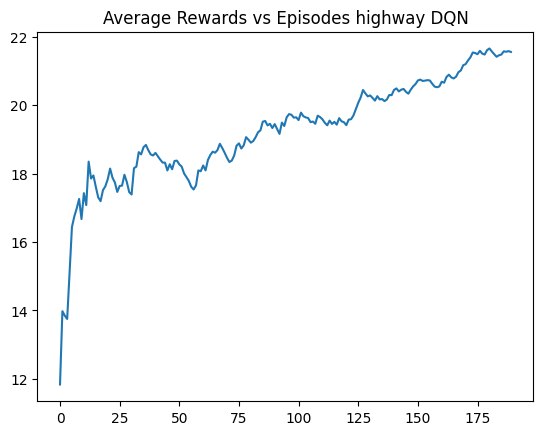

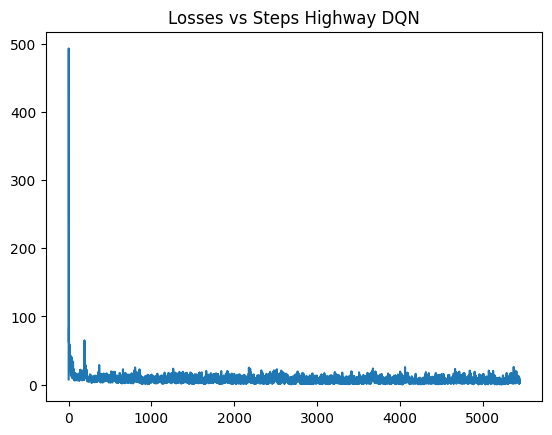

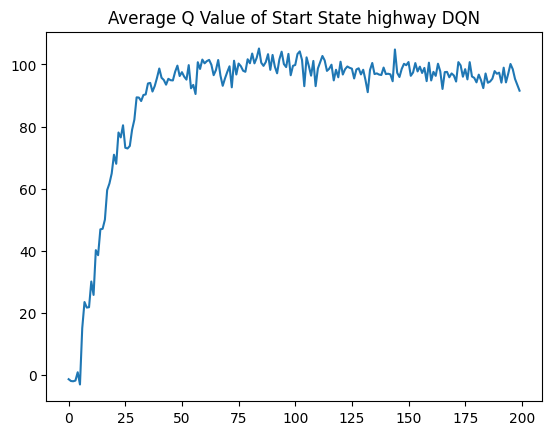

In [ ]:
#@title Plots for Highway Greyscaled DQN 

plot_dqn = []
for i in range(10,len(episode_rewards_dqn)):
  plot_dqn.append(sum(episode_rewards_dqn[:i + 1])/(i + 1))
plt.title('Average Rewards vs Episodes highway DQN')
plt.plot(plot_dqn)
plt.show()

plt.plot(losses_dqn)
plt.title('Losses vs Steps Highway DQN')
plt.show()

plt.plot(avg_qval_dqn)
plt.title('Average Q Value of Start State highway DQN')
plt.show()


Episodes 0
Avg Reward 42.10666666666671
Episodes 10
Avg Reward 41.92484848484849
Episodes 20
Avg Reward 41.820952380952384
Episodes 30
Avg Reward 41.78408602150536
Episodes 40
Avg Reward 41.86276422764227
Episodes 50
Avg Reward 41.36287581699344
Episodes 60
Avg Reward 41.45202185792346
Episodes 70
Avg Reward 41.54422535211264
Episodes 80
Avg Reward 41.66304526748969
Episodes 90
Avg Reward 41.68981684981683
Episodes 100
Avg Reward 41.691485148514836
Episodes 110
Avg Reward 41.74690690690689
Episodes 120
Avg Reward 41.77663911845728
Episodes 130
Avg Reward 41.817099236641205
Episodes 140
Avg Reward 41.866004728132374


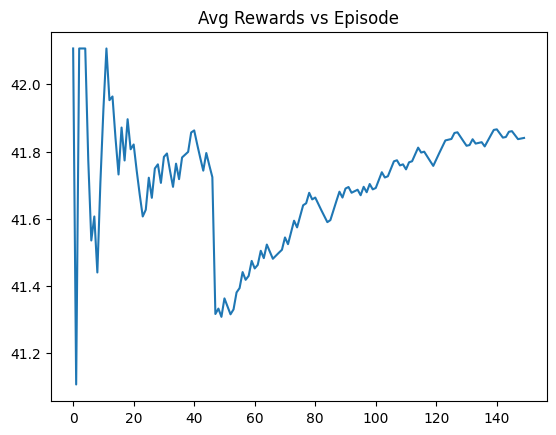

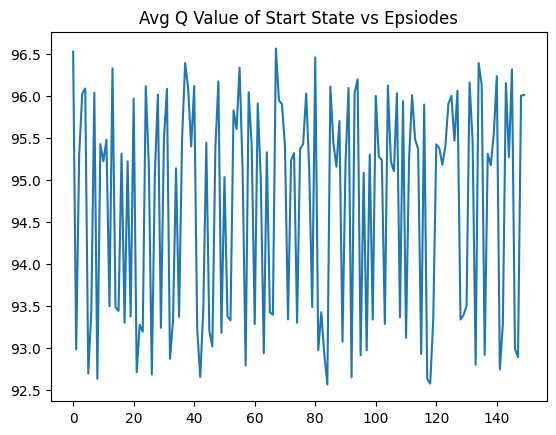

In [ ]:
#@title Evaluating Highway Greyscaled DQN

evaluate(env,policy_net)

In [ ]:
#@title DDQN for Highway GreyScaled
if torch.cuda.is_available():
    num_episodes = 200
else:
    num_episodes = 200

env = gym.make("highway-fast-v0")
config = {
       "observation": {
           "type": "GrayscaleObservation",
           "observation_shape": (128, 64),
           "stack_size": 4,
           "weights": [0.2989, 0.5870, 0.1140],  # weights for RGB conversion
           "scaling": 1.75,
       },
       "policy_frequency": 2
   }
env.configure(config)
env.config["lanes_count"] = 6

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
state = state.flatten()
n_observations = len(state)

policy_net = ANN(n_observations, n_actions).to(device)
target_net = ANN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)



eps_done = 0
episode_rewards_ddqn = np.array([])
avg_qval_ddqn = []
losses_ddqn = []
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = state.flatten()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    avg_qval_ddqn.append(torch.mean(policy_net(state)).item())


    

    ep_reward = 0
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        observation = observation.flatten()
        ep_reward += reward
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        loss = optimize_model_ddqn()
        if loss:
          losses_ddqn.append(loss.item())

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_rewards_ddqn = np.append(episode_rewards_ddqn,ep_reward)
            eps_done += 1
            if eps_done%10 == 0:
              print('Episodes', eps_done)
              print('Avg Reward', np.mean(episode_rewards_ddqn))
            break
        

print('Complete')

/usr/local/lib/python3.9/dist-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


Episodes 10
Avg Reward 15.139512573650967
Episodes 20
Avg Reward 13.331421935243394
Episodes 30
Avg Reward 12.786736624528034
Episodes 40
Avg Reward 14.531406757774889
Episodes 50
Avg Reward 14.741788023497325
Episodes 60
Avg Reward 14.027796164874683
Episodes 70
Avg Reward 14.620633381563628
Episodes 80
Avg Reward 15.107946941926173
Episodes 90
Avg Reward 15.378763724282306
Episodes 100
Avg Reward 15.565840526102333
Episodes 110
Avg Reward 15.90016645319579
Episodes 120
Avg Reward 15.789641922284558
Episodes 130
Avg Reward 16.095900873415065
Episodes 140
Avg Reward 16.371101931958858
Episodes 150
Avg Reward 16.222918065881306
Episodes 160
Avg Reward 16.13606855977303
Episodes 170
Avg Reward 16.126156521502725
Episodes 180
Avg Reward 16.203336443300703
Episodes 190
Avg Reward 16.36100357698707
Episodes 200
Avg Reward 16.513349239669257
Complete


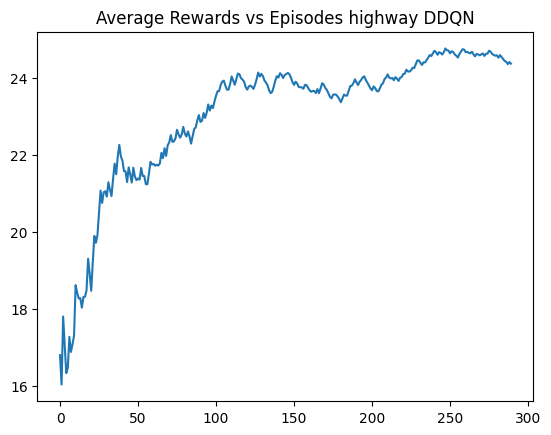

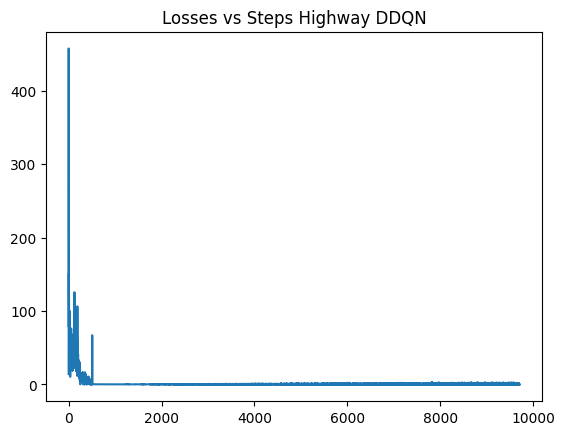

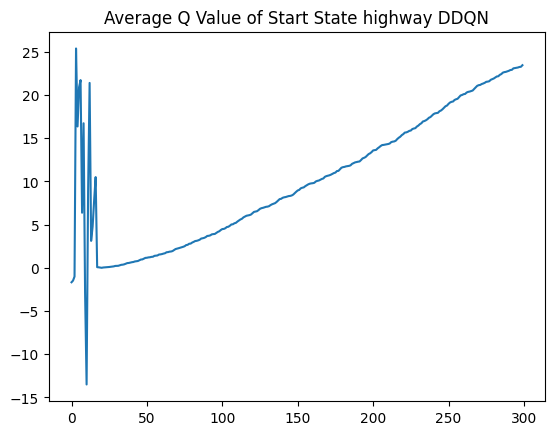

In [ ]:
#@title Plots for Highway Greyscaled DDQN 

plot_ddqn = []
for i in range(10,len(episode_rewards_ddqn)):
  plot_ddqn.append(sum(episode_rewards_ddqn[:i + 1])/(i + 1))
plt.title('Average Rewards vs Episodes highway DDQN')
plt.plot(plot_ddqn)
plt.show()

plt.plot(losses_ddqn[:])
plt.title('Losses vs Steps Highway DDQN')
plt.show()

plt.plot(avg_qval_ddqn[:])
plt.title('Average Q Value of Start State highway DDQN')
plt.show()


Episodes 0
Avg Reward 50.000000000000036
Episodes 10
Avg Reward 37.00000000000002
Episodes 20
Avg Reward 33.32063492063493
Episodes 30
Avg Reward 34.334408602150546
Episodes 40
Avg Reward 33.495121951219524
Episodes 50
Avg Reward 32.827450980392165
Episodes 60
Avg Reward 32.604371584699464
Episodes 70
Avg Reward 31.672769953051652
Episodes 80
Avg Reward 31.727983539094655
Episodes 90
Avg Reward 31.291208791208803
Episodes 100
Avg Reward 31.401650165016505
Episodes 110
Avg Reward 30.776876876876884
Episodes 120
Avg Reward 30.733057851239675
Episodes 130
Avg Reward 30.74631043256998
Episodes 140
Avg Reward 30.794799054373527


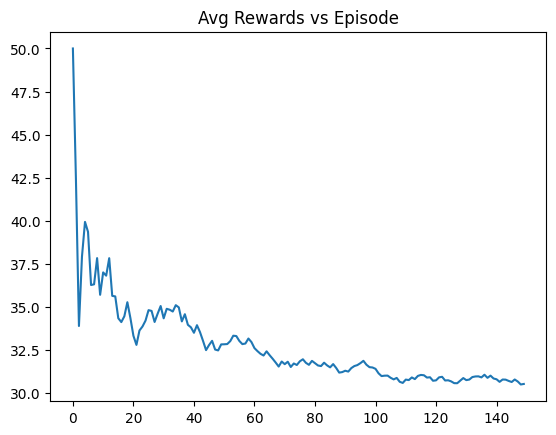

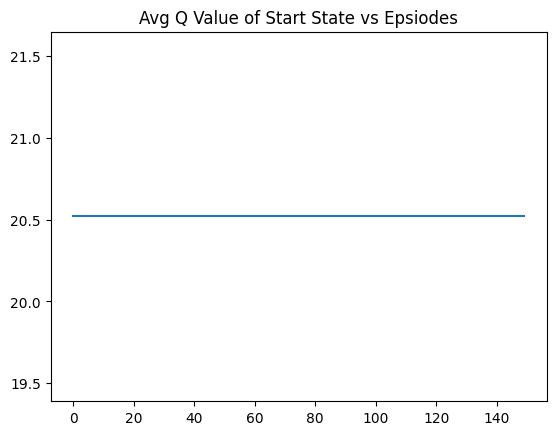

In [ ]:
#@title Evaluating Highway Greyscaled DDQN

evaluate(env,policy_net)

In [ ]:
#@title PERDQN for Highway GreyScaled

UPDATE_NN_EVERY = 1        # how often to update the network
BUFFER_SIZE = int(1e5)      # replay buffer size

# prioritized experience replay
UPDATE_MEM_EVERY = 20          # how often to update the priorities
UPDATE_MEM_PAR_EVERY = 3000     # how often to update the hyperparameters
EXPERIENCES_PER_SAMPLING = math.ceil(BATCH_SIZE * UPDATE_MEM_EVERY / UPDATE_NN_EVERY)

env = gym.make("highway-fast-v0")
config = {
       "observation": {
           "type": "GrayscaleObservation",
           "observation_shape": (128, 64),
           "stack_size": 4,
           "weights": [0.2989, 0.5870, 0.1140],  # weights for RGB conversion
           "scaling": 1.75,
       },
       "policy_frequency": 2
   }
env.configure(config)
env.config["lanes_count"] = 6


state,_ = env.reset()
state = state.flatten()
agent = Agent(state_size=len(state), action_size=env.action_space.n)

n_episodes=200; max_t=1000; eps_start=1.0; eps_end=0.01; eps_decay=0.97;
"""Deep Q-Learning.

Params
======
    n_episodes (int): maximum number of training episodes
    max_t (int): maximum number of timesteps per episode
    eps_start (float): starting value of epsilon, for epsilon-greedy action selection
    eps_end (float): minimum value of epsilon
    eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
"""
scores = []                        # list containing scores from each episode
eps = eps_start                    # initialize epsilon


episode_rewards_perdqn = np.array([])
losses_perdqn = []
avg_qval_perdqn = []
for i_episode in range(1, n_episodes+1):
  state,_ = env.reset()
  state = state.flatten()
  avg_qval_perdqn.append(agent.avg_qval(state))

  score = 0
  for t in range(max_t):
      action = agent.act(state, eps)
      next_state, reward, done,truncated, _ = env.step(action)
      next_state = next_state.flatten()
      loss = agent.step(state, action, reward, next_state, done)
      if loss:
        losses_perdqn.append(loss.item())
      state = next_state
      score += reward
      if done:
        break 
  episode_rewards_perdqn = np.append(episode_rewards_perdqn,score)

  eps = max(eps_end, eps_decay*eps) # decrease epsilon
  if i_episode % 10 == 0:
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(episode_rewards_perdqn)))




/usr/local/lib/python3.9/dist-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


Episode 10	Average Score: 14.43
Episode 20	Average Score: 16.15
Episode 30	Average Score: 18.47
Episode 40	Average Score: 17.50
Episode 50	Average Score: 17.99
Episode 60	Average Score: 17.89
Episode 70	Average Score: 17.75
Episode 80	Average Score: 18.22
Episode 90	Average Score: 18.90
Episode 100	Average Score: 19.44
Episode 110	Average Score: 19.66
sum_prob before 1.0405289143420566
sum_prob after :  1.0000000000000018
Episode 120	Average Score: 19.86
Episode 130	Average Score: 19.65
Episode 140	Average Score: 20.61
Episode 150	Average Score: 22.02
Episode 160	Average Score: 22.90
Episode 170	Average Score: 23.17
Episode 180	Average Score: 23.83
Episode 190	Average Score: 24.04
sum_prob before 1.0295416631797532
sum_prob after :  0.9999999999999981
Episode 200	Average Score: 24.52


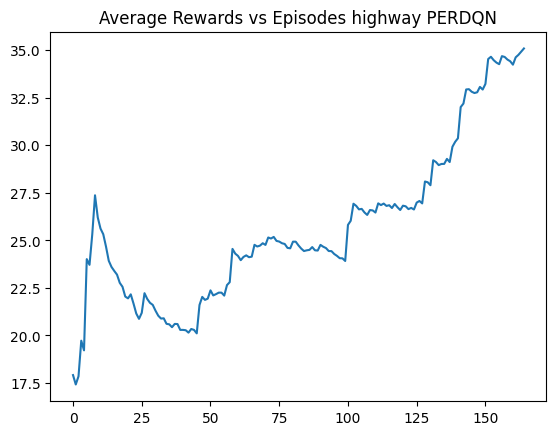

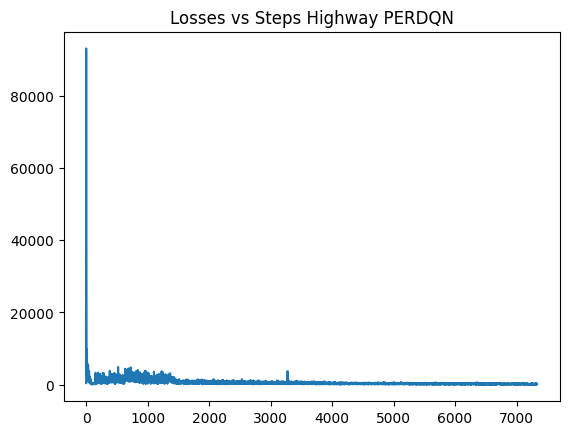

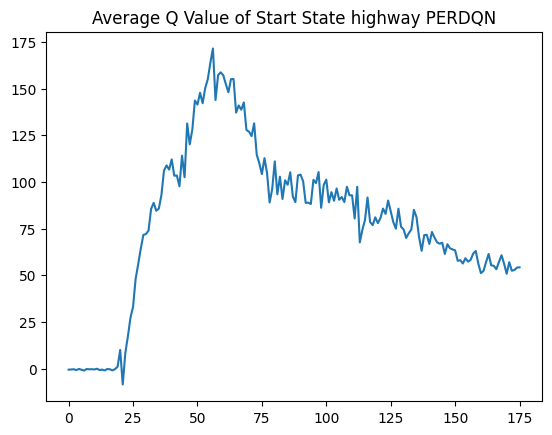

In [ ]:
#@title Plots for Highway Greyscaled PERDQN 

plot_perdqn = []
for i in range(10,len(episode_rewards_perdqn)):
  plot_perdqn.append(sum(episode_rewards_perdqn[:i + 1])/(i + 1))
plt.title('Average Rewards vs Episodes highway PERDQN')
plt.plot(plot_perdqn)
plt.show()

plt.plot(losses_perdqn[:])
plt.title('Losses vs Steps Highway PERDQN')
plt.show()

plt.plot(avg_qval_perdqn[:])
plt.title('Average Q Value of Start State highway PERDQN')
plt.show()

Episodes 0
Avg Reward 45.488764268125266
Episodes 10
Avg Reward 45.00237423058552
Episodes 20
Avg Reward 44.96964139995019
Episodes 30
Avg Reward 41.123860687059754
Episodes 40
Avg Reward 41.06704780864163
Episodes 50
Avg Reward 40.32740124274385
Episodes 60
Avg Reward 40.42400193881986
Episodes 70
Avg Reward 40.479026365600916
Episodes 80
Avg Reward 40.56243808693277
Episodes 90
Avg Reward 40.80237594035275
Episodes 100
Avg Reward 41.23020882551154
Episodes 110
Avg Reward 40.82458979217367
Episodes 120
Avg Reward 40.02993625861625
Episodes 130
Avg Reward 40.02639830779396
Episodes 140
Avg Reward 40.09660773701979


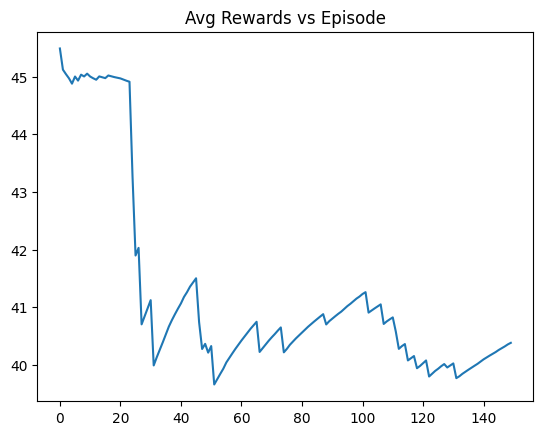

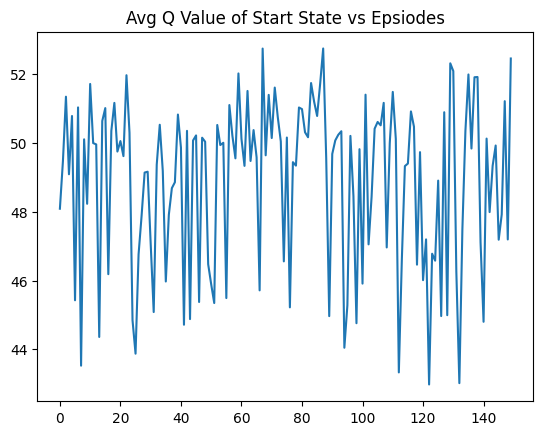

In [ ]:
#@title Evaluating Highway Greyscaled PERDQN

policy_net_perdqn = agent.qnetwork_local
evaluate(env,policy_net_perdqn)

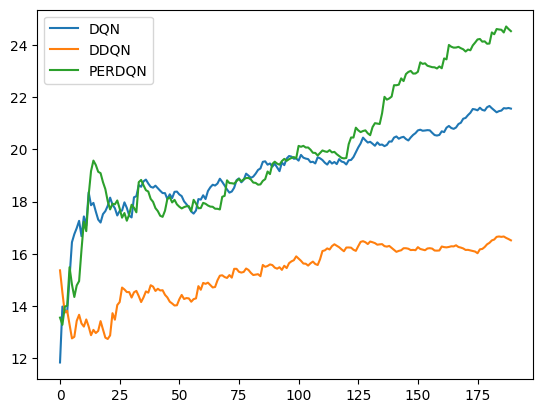

In [ ]:
#@title Plotting DQN and DDQN and PERDQN Rewards together 

plot_dqn = []
plot_ddqn = []
plot_perdqn = []
for i in range(10,len(episode_rewards_dqn)):
  plot_dqn.append(sum(episode_rewards_dqn[:i + 1])/(i + 1))
for i in range(10,len(episode_rewards_ddqn)):
  plot_ddqn.append(sum(episode_rewards_ddqn[:i + 1])/(i + 1))
for i in range(10,len(episode_rewards_perdqn)):
  plot_perdqn.append(sum(episode_rewards_perdqn[:i + 1])/(i + 1))


plt.plot(plot_dqn, label = 'DQN')
plt.plot(plot_ddqn, label = 'DDQN')
plt.plot(plot_perdqn, label = 'PERDQN')
plt.legend()
plt.show()


Q2.C 

Results: PERDQN signigicantly outperforms both DQN and DDQN. While on this run, DDQN is worse than DQN, on multiple runs it can be seen that DQN and DDQN perform very similarly. But PERDQN is always better than them. On evaluations over multiple test runs, again we observe that PERDQN is better than DQN and DDQN. Thus there is a significant benefit of Prioritized Experience Replay. 

Time Taken: Due to hardware constraints we are only abe to run for 200 episodes here. DQN and DDQN both take around 15 minutes to train. PERDQN takes longer at 35 minutes , which can be attributed to the prioritized experience replay. 

In [ ]:
#@title DQN Highway Kinematics 

EPS_DECAY = 20
env = gym.make("highway-fast-v0")
env.config["lanes_count"] = 6

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
state = state.flatten()
n_observations = len(state)

policy_net = ANN(n_observations, n_actions).to(device)
target_net = ANN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(100000)

if torch.cuda.is_available():
    num_episodes = 100
else:
    num_episodes = 100

eps_done = 0
episode_rewards_dqn = np.array([])
avg_qval_dqn = []
losses_dqn = []
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = state.flatten()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    avg_qval_dqn.append(torch.mean(policy_net(state)).item())
    ep_reward = 0
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        observation = observation.flatten()
        ep_reward += reward
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        loss = optimize_model_dqn()
        if loss:
          losses_dqn.append(loss.item())

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_rewards_dqn = np.append(episode_rewards_dqn,ep_reward)
            eps_done += 1
            if eps_done%10 == 0:
              print('Episodes', eps_done)
              print('Avg Reward', np.mean(episode_rewards_dqn))
            break
        

print('Complete')

/usr/local/lib/python3.9/dist-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


Episodes 10
Avg Reward 9.737043032859939
Episodes 20
Avg Reward 9.171728900369692
Episodes 30
Avg Reward 10.665823852329314
Episodes 40
Avg Reward 11.419747381444832
Episodes 50
Avg Reward 11.411168189048135
Episodes 60
Avg Reward 11.390960580313312
Episodes 70
Avg Reward 11.659159271665038
Episodes 80
Avg Reward 11.463641324333887
Episodes 90
Avg Reward 10.903278529397095
Episodes 100
Avg Reward 10.784881886242438
Complete


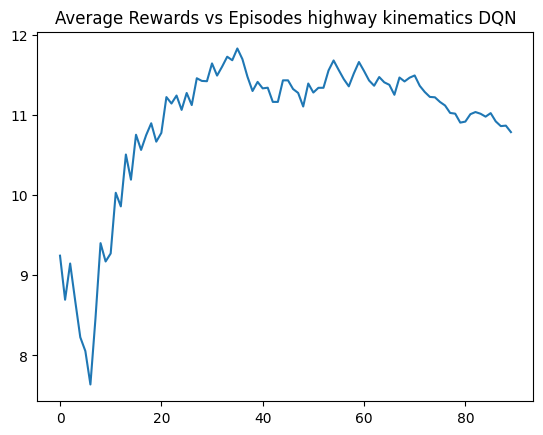

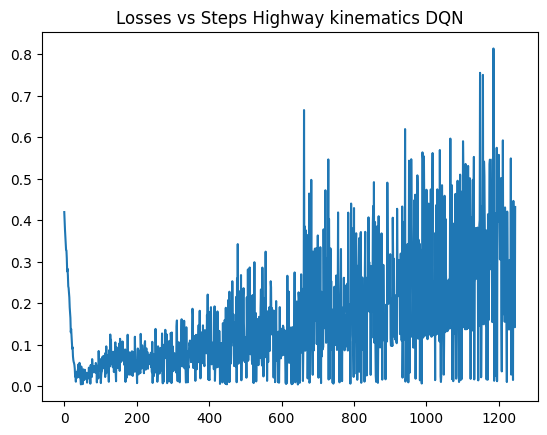

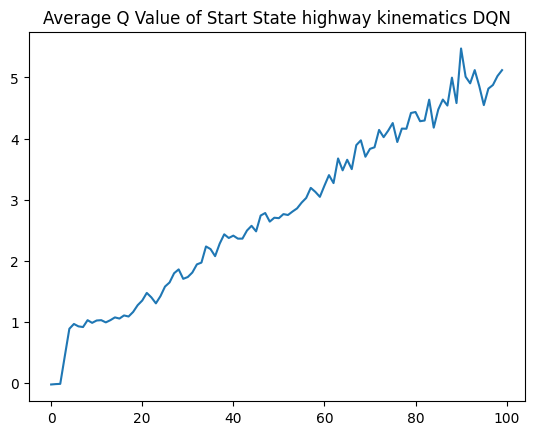

In [ ]:
#@title Plots for Highway kinematics PERDQN 

plot_dqn = []
for i in range(10,len(episode_rewards_dqn)):
  plot_dqn.append(sum(episode_rewards_dqn[:i + 1])/(i + 1))
plt.title('Average Rewards vs Episodes highway kinematics DQN')
plt.plot(plot_dqn)
plt.show()

plt.plot(losses_dqn[:])
plt.title('Losses vs Steps Highway kinematics DQN')
plt.show()

plt.plot(avg_qval_dqn[:])
plt.title('Average Q Value of Start State highway kinematics DQN')
plt.show()

Q2.D Observations:

On 100 episodes, we have

Cumulative Average Reward Kinematics DQN = 11

Cumulative Average Reward Greyscale DQN = 21 

Hence for small number of episodes, we get almost double the reward for greyscale than kinematics configuration. This could imply that we get more information from the pixels of the image than we get from the state of kinematics. 

Also we notice that at 100 episodes, the average reward is dropping for kinematics but for greyscale we have a stable, increasing trend at 100 episodes. Hence we do not get to see consistent learning for kinematics at 100 episodes, while greyscale learning is consistently happening. 

Hence between greyscale and kinematics we should prefer kinematics, because it seems to give better rewards and faster learning. 



